In [1]:
import pylab as plt
import numpy as np
import swot_ssh_utils as swot
import swot_swell_utils as swell
from cartopy import crs as ccrs
from netCDF4 import Dataset
import xarray as xr
import sys as sys
import glob as glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import datetime
from scipy import ndimage
from scipy.signal import hilbert,hilbert2,fftconvolve

from wave_physics_functions import wavespec_Efth_to_Ekxky,wavespec_Efth_to_first3

from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle
from  lib_filters_obp import *
from scipy import signal
from numpy.ma import masked_array
import cmocean
import cmocean.cm as cmo

from  spectral_analysis_functions import *
plt.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})


In [4]:
# This opens the track output WAVEWATCH III spectra file. Alternatively for just the H_18, we could use the _ef.nc output (smaller file)

modelOK=1 # set this to 0 if you do not want to use model output ... 

if (modelOK > 0):
    # at ifremer, hese files are here: /home/datawork-WW3/PROJECT/SWOT/GLOBAL/work2023-01-01T00_2023-07-01T00
    filetr='/media/ardhuin/FabLinux/WW3-SWOT/GLOBAL_REF102040/SWOT_WW3-GLOB-30M_202308_trck.nc'
    ds_ww3t = xr.open_dataset(filetr)
    moddf=ds_ww3t.frequency2.values-ds_ww3t.frequency1.values
    modf=ds_ww3t.frequency.values
    modang=np.mod(90-ds_ww3t.direction,360)
    modnth=np.shape(modang)[0]
    moddth=(2*np.pi/modnth)

Reading file: /media/ardhuin/FabLinux/SWOT2/SWOT_L3_LR_SSH_Unsmoothed_002_485_20230828T091915_20230828T101042_v1.0.1.nc
group: left , lonlat: 15.0S , lat_bounds: [-15.5, -14.5]
number of lines (alongtrack): 473 , number of pixels (crosstrack): 519
lon,lat start:: 211.78502000000003 -15.391480000000001 , lon,lat end: 211.94170000000003 -14.434600000000001
track vector: 0.95688 0.15140263110195284 -171.0088947998555 8.991105200144489 ## 0.95688 -1 33972
nxtile: 20 21 250 235
Nb of points OBP kernel: 39
Nb of points OBP kernel: 41
Nb of points OBP kernel: 241
Tm02: 5.072487 1.1355726 7.351734 2.4754872 7.718333598304587
Tm02 cut 250: 4.8058896 1.0641491 6.5473166 2.818937 8.7891776311214


/home/ardhuin/.local/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Hs1,Hs2: 1.1355726 1.0816892070891906
dkx: 0.0002 0.00020263424518743664 0.0002 0.00020263424518743666 6.666666666666626e-05 6.754474839581331e-05
Max: 18.839513608101413 2708.3311471950874 53.854878690202774 7.718333598304587 8.7891776311214 Hs: 1.1355726 1.1355725526809757 1.0641491
Az cut-off: 0.34781522 261.5888 0.2896479286639001 2.42754213245004e-05 0.7117868097997403 0.21992197030926977 (40, 42)
sum of coarsened model spectrum at  -147.5 -15.0  : 0.004584654398321092 0.2708403041889029 max med: 434.0652 30.560950000000002
Emax: 325.6139440579185 -0.003 0.003 -0.003 0.003
Swell mask option: 7 1 -5 0.3 0.18888156286994714 21 30.560950000000002


/tmp/ipykernel_13978/147238137.py:337: RuntimeWarning: divide by zero encountered in log10
  im=ax[0].pcolormesh(-kxm[ix1:ix1+nxtile*6]*1000,-kym[iy1:iy1+nxtile*6]*1000,10*np.log10(Ekxky[ix1:ix1+nxtile*6,iy1:iy1+nxtile*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE+10, vmax=30+dBE+10)


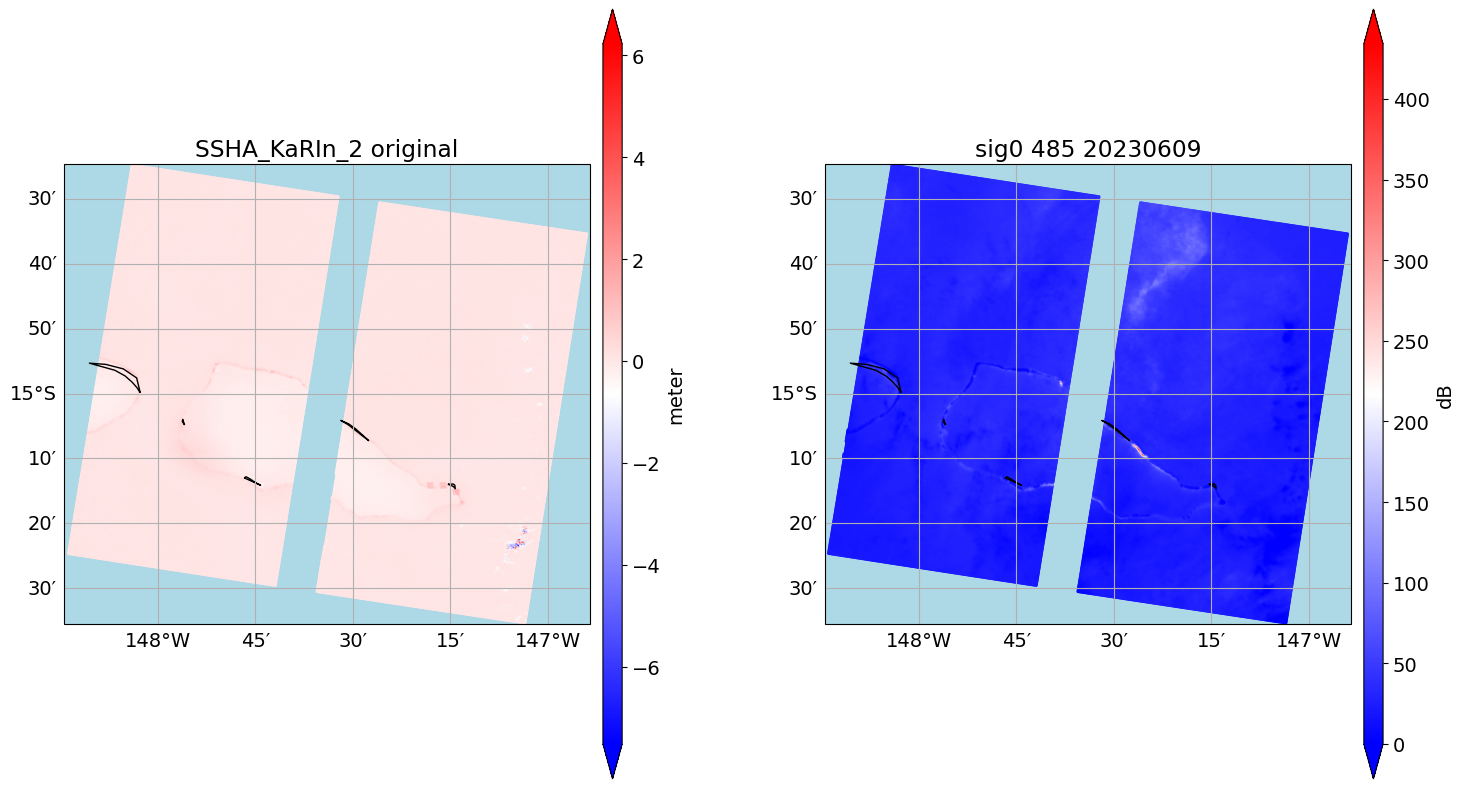

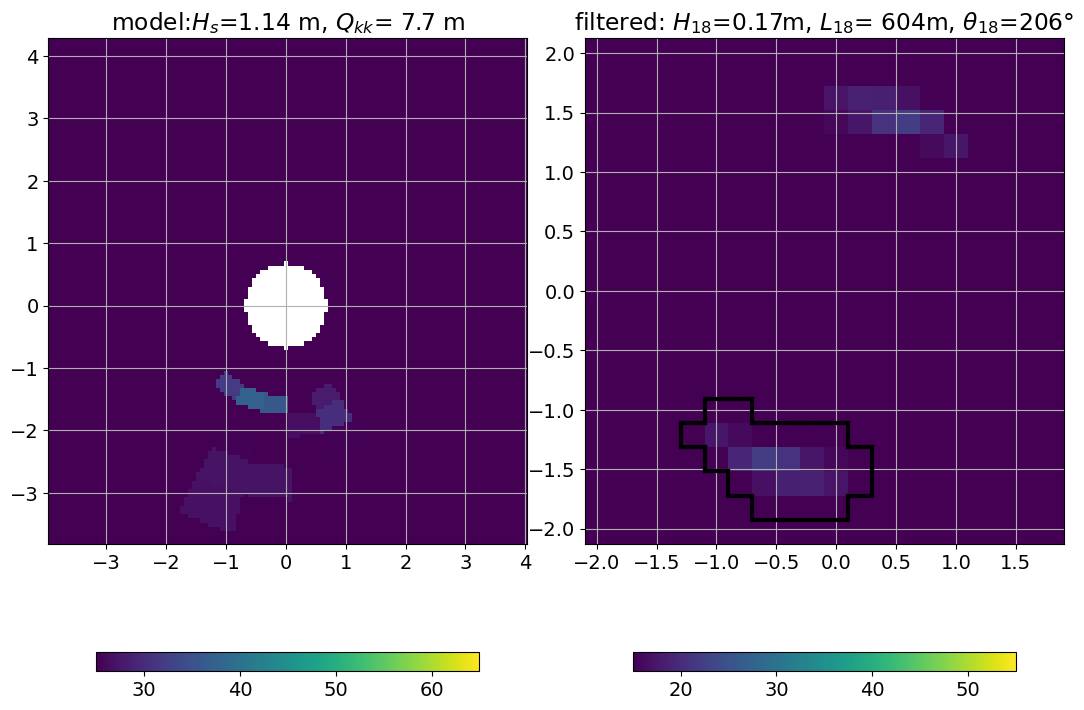

Hs from SWOT : 0.028708470080784452 0.05912246626422683 0.1384186700539979
Lm,dm from SWOT: 603.5398231686074 205.91555526458393
Hs from WW3: 0.04175108972478325 0.1673198450069755 ## 0.190480693359136
Lm, dm from WW3: 604.1339163250636 206.0154533777192 -171.0088947998555


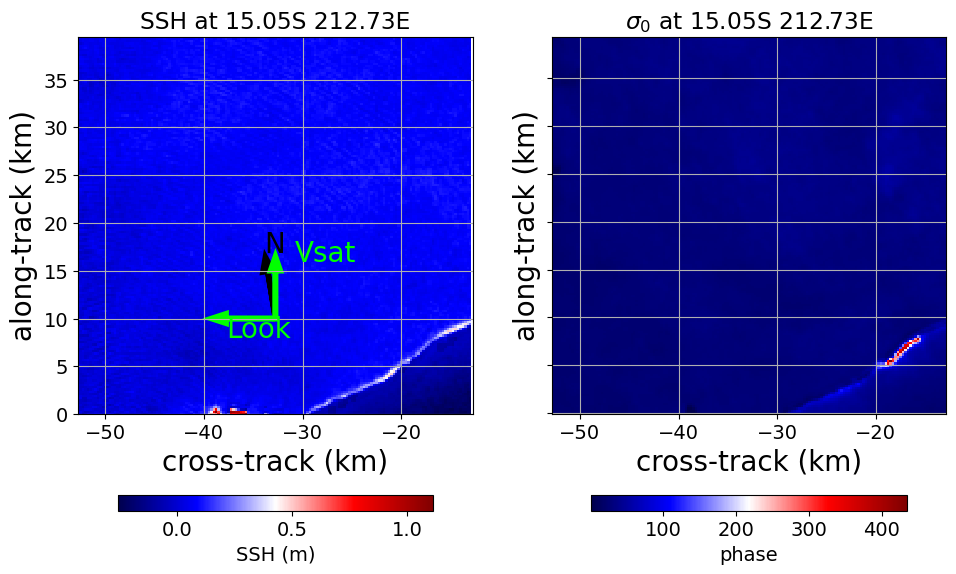

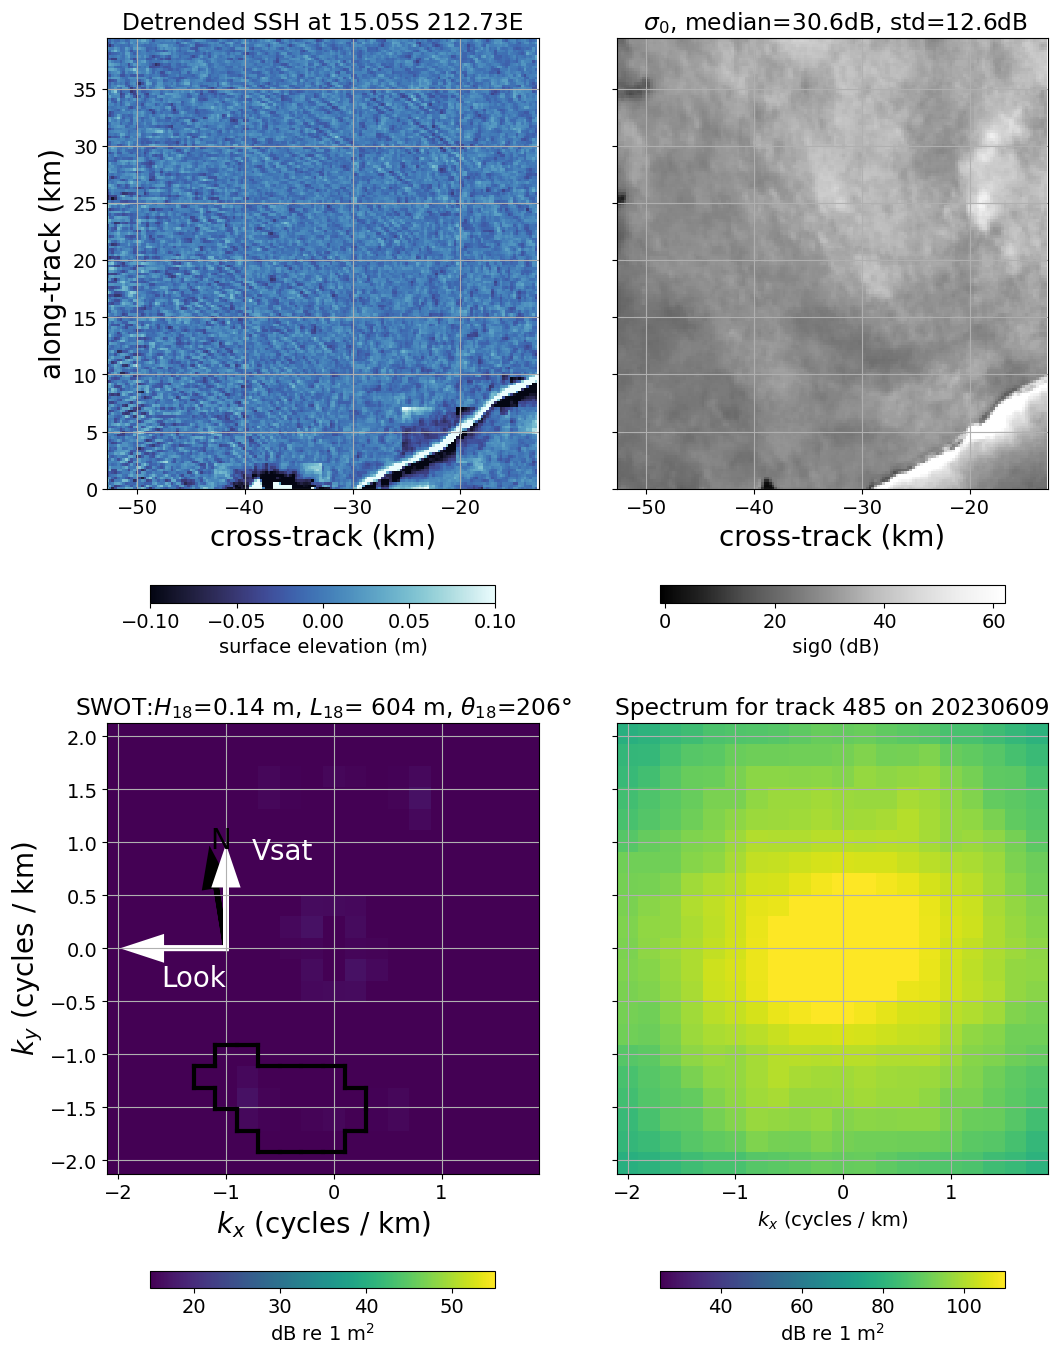

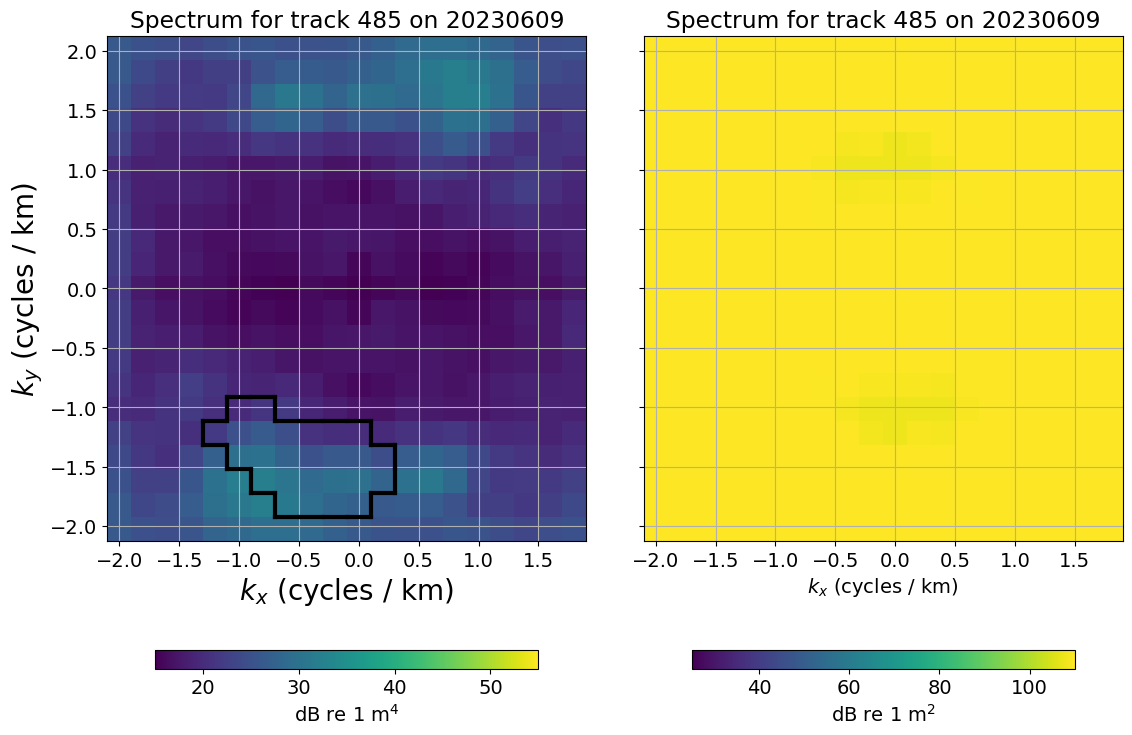

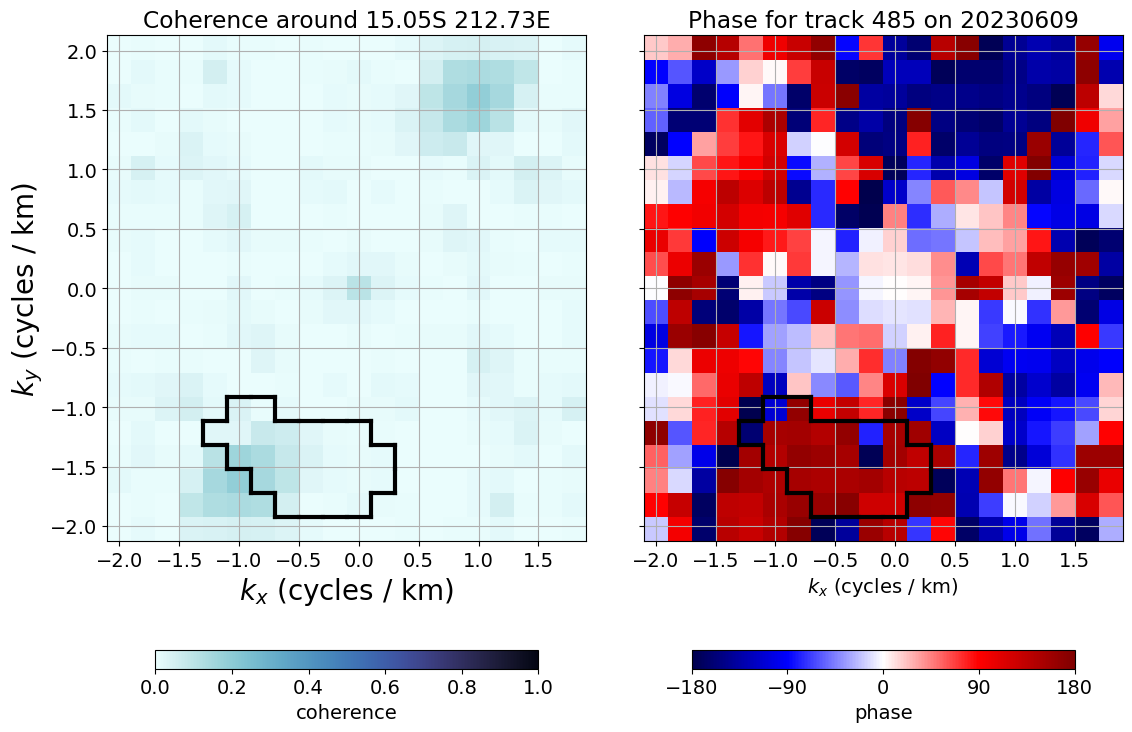

In [5]:
hemiNS=['A','N','S']
hemiWE=['A','E','W']

dBE=0

lightcmap = cmocean.tools.lighten(cmo.ice, 1)
lightcmap2 = cmocean.tools.lighten(cmo.ice_r, 1)
    
pth_swot='/media/ardhuin/FabLinux/SWOT1/'  # this is for the beta data
pth_swot='/media/ardhuin/FabLinux/SWOT2/'  # this is for the updated data
pth_results=''


cohthr=0.3; flagssha=1E10;
fs1=20; # font size
fshrink=0.8;

nm=0;mm=0;
calibration=1.


# Defines area for spectral analysis 
dx=250
dy=235

    
# Defines area for spectral analysis 
nX2=80 #40 #40 #80 # 20 # 40
nY2=84 #*2 #42 #42 #84 #42

# To select a sample of data, just uncomment one of the lines with "days= ... "
# Samples in Fig. 1 of Ardhuin et al. (GRL 2024) 
cycle='546';days='20230609';tracks='019';latc=-47.15;side='right';n=8;m=8;dBE=10;dBE2=20;amax=0.1;mask_choice=0   # sample A new

#cycle='547'; days='20230609';tracks='008';latc=-9.4; side='left';n=8;m=4;dBE=0;dBE2=10;amax=0.1;mask_choice=0   # sample A old
#cycle='548';days='20230610';tracks='008';latc=-9.2; side='left';n=8;m=8;dBE=20;dBE2=30;amax=0.1;mask_choice=0   # sample A+1
#cycle='547';days='20230610';tracks='021';latc=-45.4;side='right';n=8;m=8;dBE=0;dBE2=10;amax=0.1;mask_choice=1  # sample B
#cycle='548';days='20230611';tracks='017';latc=-29.3; side='left';n=8;m=8;dBE=0;dBE2=10;mask_choice=2;          # sample C

# Samples in Fig. S1 
# sample D, station PAPA
#cycle='556';days='20230618';tracks='015';latc=49.9;side='right';n=8;m=8;dBE=0;dBE2=10;amax=0.05;mask_choice=-4
#cycle='556';days='20230618';tracks='015';latc=49.9;side='right';n=8;m=4;dBE=0;dBE2=10;amax=0.05;mask_choice=-4
# sample E, buoy 10379
#cycle='545';days='20230607';tracks='010';latc=-41.0;side='left';n=8;m=8;dBE=20;dBE2=30;amax=0.5;mask_choice=-5
# Compute convolution
#cycle='546';days='20230607';tracks='010';latc=-41.0;side='left';n=8;m=8;dBE=20;dBE2=30;amax=0.5;mask_choice=-5

#cycle='548';days='20230607';tracks='019';latc=-47.0;side='left';n=8;m=8;dBE=20;dBE2=30;amax=0.5;mask_choice=-5

#cycle='547';days='20230607';tracks='019';latc=-41.0;side='right';n=8;m=8;dBE=20;dBE2=30;amax=0.5;mask_choice=-5
#cycle='547';days='20230607';tracks='006';latc=-40.5;side='right';n=8;m=8;dBE=20;dBE2=30;amax=0.5;mask_choice=-5

# sample F, buoy 1210
#cycle='547';days='20230609';tracks='010';latc=-26.2;side='left';n=8;m=8;dBE=10;dBE2=20;amax=0.2;mask_choice=-5   
# sample G, buoy 010253
#cycle='546';days='20230608';tracks='008';latc=-49.4;side='right';n=8;m=8;dBE=20;dBE2=30;amax=0.5;mask_choice=-5   

# sample G, buoy 010253
#cycle='549';days='20230608';tracks='004';latc=-29.1;side='right';n=8;m=8;dBE=15;dBE2=25;amax=0.2;mask_choice=0  

# more interesting cases with buoy data
# Let's calle this "sampleB8" (same location as B, but June 8)
#days='20230608';tracks='021';latc=-45.4;side='right';n=8;m=8;dBE=20;dBE2=30;amax=0.4;mask_choice=0  # sample B8
#days='20230611';tracks='004';latc=-23.2; side='left';n=8;m=8;dBE=20;dBE2=30;amax=0.1;mask_choice=0 # sample X
#days='20230610';tracks='004';latc=-29.3; side='left';n=8;m=8;dBE=0;dBE2=20;mask_choice=-1; #

# Examples with waves in ice
#cycle='543';days='20230606';tracks='023';latc=-64.5;side='left';n=8;m=8;dBE=20;dBE2=30;amax=0.4;mask_choice=0  # waves in ice
#cycle='004';tracks='351';latc=-63;side='right';n=8;m=8;dBE=0;dBE2=10;amax=0.05;mask_choice=-4


#cycle='493';tracks='013';latc=38.;side='right';n=2;m=2;dBE=0;dBE2=10;amax=0.05;mask_choice=-4   
#cycle='547';tracks='019';latc=-42.;side='right';n=2;m=2;dBE=0;dBE2=10;amax=0.05;mask_choice=-4   
#cycle='549';tracks='008';latc=-10.;side='right';n=2;m=2;dBE=0;dBE2=10;amax=0.05;mask_choice=-4   

#cycle='007'; days='20230609';tracks='274';latc=34.3; side='right';n=8;m=8;dBE=10;dBE2=10;amax=0.1;mask_choice=0   # sample A
#cycle='004'; days='';tracks='580';latc=35.4; side='left';n=8;m=8;dBE=10;dBE2=10;amax=0.1;mask_choice=0   # sample A
#cycle='014'; days='';tracks='580';latc=35.4; side='left';n=8;m=8;dBE=10;dBE2=10;amax=0.1;mask_choice=0   # sample A
#cycle='015'; days='';tracks='580';latc=35.4; side='left';n=8;m=8;dBE=10;dBE2=10;amax=0.1;mask_choice=0   #  This is for Caltech cable 

#cycle='010'; days='';tracks='148';latc=76.0; side='left';n=8;m=8;dBE=10;dBE2=10;amax=0.1;mask_choice=0   # sample A
#cycle='010'; days='';tracks='146';latc=69.0; side='left';n=8;m=8;dBE=10;dBE2=10;amax=0.1;mask_choice=0   # sample A

# Taina's case
cycle='002';addglobcur=0;side='left';tracks='485';latc=-14.5;dBE=25;dBE2=25;n=8;m=8;nm=8;mm=8; latmax=-15;latmin=-20; ddlat=0.1;skipstep=2;mask_choice=-5;mask_choice2=0;cmapmin=20;cmapmax=3;
cycle='002';addglobcur=0;side='left';tracks='485';latc=-15.0;dBE=25;dBE2=25;n=8;m=8;nm=8;mm=8; latmax=-15;latmin=-20; ddlat=0.1;skipstep=2;mask_choice=-5;mask_choice2=0;cmapmin=20;cmapmax=3;


# threshold for coherence
cfac=np.sqrt(n*m)

# loop over a single point  (this is done to keep the structure of the other notebook)
for latc in [latc]:
    # Level 2 
    #file_list = glob.glob(pth_swot+'SWOT_L2_LR_SSH_U*_'+cycle+'_'+tracks+'*.nc')
    # Level 3
    file_list = glob.glob(pth_swot+'SWOT_L3_LR_SSH_U*_'+cycle+'_'+tracks+'*.nc')
    #file_list = glob.glob(pth_swot+'SWOT_L2_LR_SSH_*_'+tracks+'_'+days+'*.nc')
    file_swot=file_list[0]
    print('Reading file:',file_swot)
    ddla = xr.open_dataset(file_swot)
    
    lat_bounds=[-0.5+float(latc), 0.5+float(latc)];
    #lonlat=f'{abs(latc):02d}'+hemiNS[int(np.sign(latc))]
    lonlat=f'{abs(latc):04.1f}'+hemiNS[int(np.sign(latc))]
    print('group:',side,', lonlat:',lonlat,', lat_bounds:',lat_bounds)

    ddl,indsub0,indsub1=swot.subset(ddla,lat_bounds)

# Preprocess data
    ssha = ddl.ssha_unedited
    flag = ddl.quality_flag
    ssha = np.where(flag < flagssha, ssha, np.nan)
    sig0 = ddl.sigma0
    flas = ddl.quality_flag
    #sig0 = np.where(flas == 0, sig0, np.nan)
    lon = ddl.longitude.values
    lat = ddl.latitude.values
    [nline,npix]=np.shape(ssha)
    X=np.arange(npix)*dx/1000
    Y=(np.arange(nline)+indsub0)*dy/1000 # warning the along-track resolutionis not exactly 250 m

    print('number of lines (alongtrack):',nline,', number of pixels (crosstrack):',npix)
    print('lon,lat start::',lon[10,10],lat[10,10],', lon,lat end:',lon[nline-10,10],lat[nline-10,10])
    dlon=lon[nline-10,10]-lon[10,10]
    dlat=lat[nline-10,10]-lat[10,10]
    midlat=0.5*(lat[nline-10,10]+lat[10,10])
    trackangle=-90-np.arctan2(dlat,dlon*np.cos(midlat*np.pi/180))*180/np.pi
    
    # Plots the long (1° latitude ) segment 
    # Create plots
    figs=2
    if figs > 1:
      fig, ax = plt.subplots(
        figsize=(18, 20),
        ncols=2,
        nrows=1,
        sharex=True,
        sharey=True,
        subplot_kw=dict(projection=ccrs.PlateCarree())
      )
    
      # Plot original data (SSH and sigma0) with a map projection, to make sure that we know were we are. 
      swot.plot_a_segment(ax[0], lon, lat, ssha, title='SSHA_KaRIn_2 original',
                         vmin=np.nanmin(ssha),vmax=np.nanmax(ssha))
    
      # Plot sig0
      sig0max=np.nanmax(sig0)
      swot.plot_a_segment(ax[1], lon, lat, sig0, title='sig0 '+tracks+' '+days,vmin=0,vmax=sig0max,cblab='dB')
    
      # Save and display plot
      fig.savefig(pth_results+'SWOT_swell_'+side+'_swath_'+cycle+'_'+tracks+'_'+lonlat+'.png',dpi=100)
    


    nxtile=nX2*2//m  # cross-track
    nytile=nY2*2//n  # along-track
    fshrink=0.8

# cross-track indices for the selected box
    i1=28+259+20  # this is for right side
    i2=i1+nX2*2
#alongtrack indices
    j1=nline //2-nY2 #10   # centers box on target latitude
    j2=j1+nY2*2
    
  
    shiftdir=trackangle
    mybox,mybos,flbox,X,Y,sflip,signMTF,Look=swell.SWOTarray_flip_north_up(dlat,side,ssha[j1:j2,i1:i2],flas[j1:j2,i1:i2],sig0[j1:j2,i1:i2],X,Y)

    print('track vector:',dlat,dlon*np.cos(midlat*np.pi/180),trackangle,trackangle+180,'##',dlat,Look,indsub0)
     
    mybox = np.where(np.isnan(mybox), 0,mybox)  
# Computes spectrum from SWOT SSH data
    print('nxtile:',nxtile,nytile,dx,dy)
    (Eta,Etb,ang,angstd,coh,crosr,phases,ky2,kx2,dky,dkx,detrenda,detrendb,nspec)=FFT2D_two_arrays_nm_detrend_flag(mybox,10**(0.1*mybos),flbox,dy,dx,n,m,detrend='quadratic') #,ffill='none')


# Prepares information for working with model spectrum
    latc=lat[j1+nY2,i1+nX2]; latcr=np.round(latc*2)/2; latcs=f'{abs(latc):3.2f}'+hemiNS[int(np.sign(latc))]
    lonc=lon[j1+nY2,i1+nX2]; loncr=np.round(lonc*2)/2; loncs=f'{abs(lonc):3.2f}'+hemiWE[int(np.sign(lonc))]
    #timea=ddla.time.values[j1+nY2]
    timec=ddl.time.values[j1+nY2]
    #print('timec:',timec,'timea:',timea)
    kxmax=-2*kx2[0,0]
    kymax=-2*ky2[0,0]
    nkxr=nxtile      # twice the SWOT range to allow aliasing computation 
    nkyr=nytile
    dkxr=kxmax/nkxr
    dkyr=kymax/(nkyr-1)  # only true in nkyr is odd ?? 
    dkxf=dkx/3;dkyf=dky/3;nkx=600;nky=600; #0.0001;dkyf=0.0001;nkx=500;nky=500
    nxavg=round(dkxr/dkxf)
    nyavg=round(dkyr/dkyf)
    kxr=np.linspace(-nkxr*dkxr,(nkxr-1)*dkxr,nkxr*2)
    kyr=np.linspace(-nkyr*dkyr,(nkyr-1)*dkyr,nkyr*2)
    fx_wreg=kxr*1000
    fy_wreg=kyr*1000
    kxr2, kyr2 = np.meshgrid(kxr,kyr,indexing='ij') 
    kn=np.sqrt(kx2**2+ky2**2)*1000

    ik1=(nxtile+1)//2;ik2=ik1+nxtile
    jk1=(nytile+1)//2;jk2=jk1+nytile
    ishift=(1-np.mod(nxtile,2))
    jshift=(1-np.mod(nytile,2))
    ix1=int(nkx-kxmax/dkxf)+nxavg*(ishift-1)
    iy1=int(nky-kymax/dkyf)+nyavg*(jshift-1)
    di1=-(nxavg//2); di2=di1+nxavg
    dj1=-(nyavg//2); dj2=dj1+nyavg

    
# Defines the spectral response H assocaited to SWOT on board processing
    from  lib_filters_obp import *
    x_xt, w_xt, f_xt, H_xt = get_obp_filter(L_filt = 0.980, f_axis = fx_wreg, plot_flag = False, kernel="parzen")
    x_at, w_at, f_at, H_at = get_obp_filter(L_filt = 1, f_axis = fy_wreg, plot_flag = False, kernel="bharris")
    x_at, w_at, f_obp, H_ptr = get_obp_filter(L_filt = 3, sampling_in = 0.0125,f_axis = fy_wreg, plot_flag = False, kernel="alejandro_azptr")
    
    H = np.repeat(np.array([H_xt]), len(H_at), axis=0).T * np.repeat(np.array([H_at]), len(H_xt), axis=0)
    Hptr = np.repeat(np.array([H_ptr]), len(H_xt), axis=0)
    H2=H*Hptr

# Looks for matching WW3 spectrum 
    modelfound=0
    if (modelOK > 0):
        modspec,indww3,modelfound,timeww3,lonww3,latww3,distww3,U10,Udir=swell.SWOTfind_model_spectrum(ds_ww3t,lonc,latc,timec)

# Computes kx,ky spectrum from WW3 on fine grid: using even number of k's makes the spectrum non-symmetric 
        if (modelfound>0):
          efth=modspec.values;
          [Ef,th1m,sth1m,Hs,Tm0m1,Tm02,Qf,Qkk] = wavespec_Efth_to_first3(efth,modf,moddf, modang.values,moddth,cut=3000.) 
          print('Tm02:',Tm02,Hs,Tm0m1,Qf,Qkk)
          [Efc,th1mc,sth1mc,Hsc,Tm0m1c,Tm02c,Qfc,Qkkc] = wavespec_Efth_to_first3(efth,modf,moddf, modang.values,moddth,cut=150.) 
          print('Tm02 cut 250:',Tm02c,Hsc,Tm0m1c,Qfc,Qkkc)
          source='model';[Ekxky,kxm,kym,kx2m,ky2m]=wavespec_Efth_to_Ekxky(efth,modf,moddf, modang,moddth,dkx=dkxf,dky=dkyf,nkx=nkx,nky=nky,doublesided=0,verbose=1,trackangle=(trackangle+sflip*180)*np.pi/180)
          
# Coarsening of WW3 spectrum on kx,ky grid 
          Ekxkyr=np.zeros((nkxr*2,nkyr*2))
          Ekxkyp=np.zeros((nkxr*2,nkyr*2))
        # We have to deal with the non-symmetry of the spectrum : hence the np.roll 
          Ekxkyds=0.5*(Ekxky+np.fliplr(np.roll( np.flipud(np.roll(Ekxky,-1,axis=0)),-1,axis=1) ))
          Ekxkydp=np.fliplr(np.roll( np.flipud(np.roll(Ekxky,-1,axis=0)),-1,axis=1) )
# Coarsening of WW3 spectrum on kx,ky grid 
        # We have to deal with the non-symmetry of the spectrum for even numbers (nxtile or nytile) 
          memo=Ekxkyds
          dkxm=kxm[1]-kxm[0]
          dkym=kym[1]-kym[0]
            
          print('dkx:',dkxr,dkyr,dkx,dky,kxm[1]-kxm[0],kym[1]-kym[0])
          #Ekxkyds=fftconvolve(memo,memo,mode='same')*dkxm*dkym*(kx2m*850/20)**2*10
          Etot=np.sum(memo)*dkxm*dkym
          C0=np.sum(memo**2)*dkxm*dkym
            
          Q=np.sqrt(np.sum(memo**2)*dkxm*dkym/Etot**2)
          
          print('Max:',C0,np.max(Ekxkyds),Q,Qkk,Qkkc,'Hs:',Hs,4*np.sqrt(Etot),Hsc)
#        Max: 2036903.636863114 152090.1761276259 60.64163861864719 3.659608777753056 Hs: 7.652041435241699 7.652041586664888

          for ix in range(nkxr*2): 
            for iy in range(nkyr*2): 
                Ekxkyr[ix,iy]=np.mean(Ekxkyds[ix1+ix*nxavg+di1:ix1+ix*nxavg+di2,iy1+iy*nyavg+dj1:iy1+iy*nyavg+dj2].flatten())
                Ekxkyp[ix,iy]=np.mean(Ekxkydp[ix1+ix*nxavg+di1:ix1+ix*nxavg+di2,iy1+iy*nyavg+dj1:iy1+iy*nyavg+dj2].flatten())


          Eta_WW3=Ekxkyr   # this is the WW3 spectrum on SWOT grid + double-sided
          sigu=(Hsc/4)*2*np.pi/Tm02c
          kc=(7310/875.0e3)/sigu/(2*np.pi)   # az cut-off wavenumber in cpk 
          Hazc = np.exp(-(kyr2/kc)**2)        # this is the effect of velocity bunching for sigma0 ... what about the phase? 
          H2=H*Hptr*Hazc
          print('Az cut-off:',sigu,1/kc,Hazc[0,0],Hptr[0,0],Hazc[0,10],Hptr[0,10],np.shape(Hazc))
        
          Sw_obp_H  = H  * Hazc * Eta_WW3
          Sw_obp_H2 = H2 * Eta_WW3
# 4) Downsample in space to the target spatial frequency
          fx_alias, fy_alias, Sw_alias_H = compute_aliased_spectrum_2D(f_xt, f_at, Sw_obp_H, 1/0.250, 1/0.235, nrep=1)
          fx_alias, fy_alias, Sw_alias_H2 = compute_aliased_spectrum_2D(f_xt, f_at, Sw_obp_H2, 1/0.250, 1/0.235, nrep=1)
    
    
# 3) Apply filter
          vars=np.sum(Ekxkyr.flatten())*dkxr*dkyr
          print('sum of coarsened model spectrum at ',lonww3,latww3,' :',vars,4*np.sqrt(vars),'max med:',np.nanmax(mybos),np.nanmedian(mybos) )
          fshrink=0.8;

    
##################################################################################
    if (modelfound > 0):
        Eta_WW3_c=Ekxkyr[ik1:ik2,jk1:jk2].T  # this is the WW3 spectrum*OBP filter with alias effect 
        Eta_WW3_ob1_H=Sw_obp_H[ik1:ik2,jk1:jk2].T
        Eta_WW3_obp_H=Sw_alias_H[ik1:ik2,jk1:jk2].T
        Eta_WW3_ob1_H2=Sw_obp_H2[ik1:ik2,jk1:jk2].T
        Eta_WW3_obp_H2=Sw_alias_H2[ik1:ik2,jk1:jk2].T
# Also computes the spectrum without aliasing to check on filter + aliasing effects 
        Eta_WW3_noa_H2=Sw_obp_H2[ik1:ik2,jk1:jk2].T
        Eta_WW3_res= H2[ik1:ik2,jk1:jk2].T * Ekxkyp[ik1:ik2,jk1:jk2].T

    # Defines swell mask  : uses function SWOTdefine_swell_mask
    HH =H[ik1:ik2,jk1:jk2].T
    HH2=H2[ik1:ik2,jk1:jk2].T
    
    spec_for_mask=Eta/HH2
    if mask_choice == -3 :
       spec_for_mask=Eta_WW3_noa_H2/HH2
    if mask_choice == -4 :
       spec_for_mask=Eta_WW3_noa_H2
    if mask_choice == -5 :
       spec_for_mask=Eta_WW3_res

    amask,bmask=swell.SWOTdefine_swell_mask(mybox,mybos,flbox,dy,dx,nm,mm,spec_for_mask,coh,ang,dlat,mask_choice,kx2,ky2,kn,cohthr,cfac,n,m,nkxr,nkyr)

    vertices=swell.SWOTspec_mask_polygon(Eta,amask) 


    
                
# Computes model parameters ... 
    if (modelfound > 0):
        Eta_WW3_obp_H2_mask=np.where( bmask > 0.5, Eta_WW3_obp_H2,0) 
        var2=np.sum(Eta_WW3_obp_H2.flatten())*dkxr*dkyr; 
        var3=np.sum(Eta_WW3_c.flatten())*dkxr*dkyr;
        Hs_WW3_all=4*np.sqrt(var2)
        Hs_WW3_cut=4*np.sqrt(var3)
        Hs_WW3_mask,Lm_WW3,Lmnew,dm_WW3=swell.SWOTspec_to_HsLm(Eta_WW3_obp_H2,kx2,ky2,bmask,HH2,trackangle)

        
    Eta_SWOT_mask=np.where( amask > 0.5, Eta,0) 
    
    varm=np.sum(Eta.flatten())*dkx*dky;
    var0=np.sum(Eta_SWOT_mask.flatten())*dkx*dky*2;
    Hs_SWOT_all=4*np.sqrt(varm)
    Hs_SWOT=4*np.sqrt(var0)
    Hs_SWOT_mask,Lm_SWOT,Lmnew,dm_SWOT=swell.SWOTspec_to_HsLm(Eta,kx2,ky2,amask,HH2,trackangle)

##################################################"
# Plotting model spectra 
    if (modelfound > 0):
        fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10.8,8.5))
        plt.subplots_adjust(left=0.05,bottom=0.07, top=0.92,wspace=0.12,right=0.99)
        im=ax[0].pcolormesh(-kxm[ix1:ix1+nxtile*6]*1000,-kym[iy1:iy1+nxtile*6]*1000,10*np.log10(Ekxky[ix1:ix1+nxtile*6,iy1:iy1+nxtile*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE+10, vmax=30+dBE+10)
        _=plt.colorbar(im,ax=ax[0],label='', location='bottom',shrink=fshrink)
        Htxt=r'$H_{s}$='+f'{Hs:4.2f}'+' m'
        arx0=0;arxd=0.4;ary0=-1.4;aryd=0.5
        #ax[1].text(arx0-4*arxd,ary0, Htxt,fontsize=16,color='w')
        Ltxt=r'$Q_{kk}$='+f'{Qkk:4.1f}'+' m'
        #ax[1].text(arx0-4*arxd,ary0-0.8*aryd, Ltxt,fontsize=16,color='w')
        Ttxt=r'$\theta_{18}$='+f'{dm_WW3:3.0f}'+'°'
        #ax[1].text(arx0-4*arxd,ary0-1.6*aryd, Ttxt,fontsize=16,color='w')
        _=ax[0].set_title('model:'+Htxt+', '+Ltxt)
 #plt.setp(axs[1].get_yticklabels(), visible=False)
          
    
        im=ax[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10(Eta_WW3_obp_H2),cmap='viridis',rasterized=True,vmin = -10+dBE, vmax=30+dBE)
        _=plt.colorbar(im,ax=ax[1],label='', location='bottom',shrink=fshrink)
        for ind in range(len(vertices) // 4):
            xy2=np.asarray(vertices[ind*4:(ind+1)*4], dtype=np.float64)
            ax[1].plot(kxr[ik1]*1000+1000*dkx*xy2[0:2],kyr[jk1]*1000+1000*dky*xy2[2:4], color='k',lw=3)
        Htxt=r'$H_{18}$='+f'{Hs_WW3_mask:4.2f}'+'m'
        arx0=0;arxd=0.4;ary0=-1.4;aryd=0.5
        #ax[1].text(arx0-4*arxd,ary0, Htxt,fontsize=16,color='w')
        Ltxt=r'$L_{18}$='+f'{Lm_WW3:4.0f}'+'m'
        _=ax[1].set_title('filtered: '+Htxt+', '+Ltxt+', '+Ttxt)

         
        plt.show()
        fig.savefig(pth_results+'WW3_swell_'+cycle+'_'+tracks+side+'_'+lonlat+'i'+f'{i1:03d}'+'j'+f'{j1:03d}'+'.pdf')

    print('Hs from SWOT :',Hs_SWOT, Hs_SWOT_all, Hs_SWOT_mask)
    print('Lm,dm from SWOT:',Lm_SWOT,dm_SWOT)
    if (modelfound > 0):
        print('Hs from WW3:',Hs_WW3_all,Hs_WW3_mask,'##',Hs_WW3_cut )
        print('Lm, dm from WW3:',Lm_WW3,dm_WW3,shiftdir)
    
    Y=Y-Y[j1]
    fig,axs=plt.subplots(1,2,figsize=(11.2,7))#,sharey=True,sharex=True)
    im=axs[0].pcolormesh(X[i1:i2],Y[j1:j2],mybox,rasterized=True, cmap='seismic',norm = mcolors.Normalize(vmin = np.nanmin(mybox), vmax=np.nanmax(mybox)))
    clb=plt.colorbar(im,ax=axs[0],label='SSH (m)', location='bottom',shrink=fshrink)
      
    arx0=X[(i1+i2)//2];ary0=10;arxd=5;aryd=5;arwid=1;gr=[0.,1,0.]
    axs[0].arrow(arx0, ary0, arxd*np.sign(dlat)*np.sin(trackangle*np.pi/180), -np.sign(dlat)*aryd*np.cos(trackangle*np.pi/180), linewidth=4,color='k',head_width=arwid) 
    axs[0].text(arx0+arxd*1.4*np.sign(dlat)*np.sin(trackangle*np.pi/180),ary0-np.sign(dlat)*aryd*1.4*np.cos(trackangle*np.pi/180),'N',fontsize=fs1)
    axs[0].arrow(arx0, ary0, 0., 5*np.sign(dlat), linewidth=4,color=gr,head_width=arwid) 
    axs[0].text(arx0+0.4*arxd,ary0+aryd*1.2*np.sign(dlat),'Vsat',fontsize=fs1,color=gr)
    axs[0].arrow(arx0, ary0 ,  arxd*Look, 0, linewidth=4,color=gr,head_width=arwid) 
    axs[0].text(arx0+arxd*Look,ary0-2,'Look',fontsize=fs1,color=gr)
        
    _=axs[0].set_xlabel('cross-track (km)', fontsize=fs1)
    _=axs[0].set_ylabel('along-track (km)',fontsize=fs1)
    _=axs[0].set_title('SSH at '+latcs+' '+loncs)
    axs[0].set_xlim((X[i1],X[i2]))
    axs[0].set_ylim((Y[j1],Y[j2]))
      
    im=axs[1].pcolormesh(X[i1:i2],Y[j1:j2],mybos,cmap='seismic',rasterized=True)
    _=plt.colorbar(im,ax=axs[1],label='phase', location='bottom',shrink=fshrink)
    _=axs[1].set_xlabel('cross-track (km)', fontsize=fs1)
    _=axs[1].set_ylabel('along-track (km)',fontsize=fs1)
    _=axs[1].set_title(r'$\sigma_0$ at '+latcs+' '+loncs)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    fig.savefig(pth_results+'SWOT_map_'+cycle+'_'+tracks+side+'_'+lonlat+'i'+f'{i1:03d}'+'j'+f'{j1:03d}'+'.pdf')  #ng',dpi=50)

        
####################################################    
    fig,ax2s=plt.subplots(2,2,figsize=(10.8,14));axs=ax2s.T.flatten()
    plt.subplots_adjust(left=0.05,bottom=0.07, top=0.92,wspace=0.12,right=0.99)


# warning: we use an array img1 that is written with X in the first (number 0) dimension and Y in the second
#          but pcolormesh uses the opposite order: hence the use of transpose 

    im=axs[0].pcolormesh(X[i1:i2],Y[j1:j2],detrenda,rasterized=True, cmap=lightcmap,vmin=-amax,vmax=amax) 
    _=plt.colorbar(im,ax=axs[0],label='surface elevation (m)', location='bottom',shrink=fshrink)
    _=axs[0].set_xlabel('cross-track (km)', fontsize=fs1)
    _=axs[0].set_ylabel('along-track (km)',fontsize=fs1)
    _=axs[0].set_title('Detrended SSH at '+latcs+' '+loncs)
    axs[0].set_xlim((X[i1],X[i2]))
    axs[0].set_ylim((Y[j1],Y[j2]))
    
    sig0mean=np.nanmedian(mybos)
    sig0std=np.nanstd(mybos)

    im=axs[2].pcolormesh(X[i1:i2],Y[j1:j2],mybos,cmap='Greys_r',rasterized=True,vmax=sig0mean+2.5*sig0std,vmin=sig0mean-2.5*sig0std)
    _=plt.colorbar(im,ax=axs[2],label=' sig0 (dB)', location='bottom',shrink=fshrink)
    _=axs[2].set_xlabel('cross-track (km)', fontsize=fs1)
    _=axs[2].set_title(r' $\sigma_0$, median='+f'{abs(sig0mean):4.1f}'+'dB, std='+f'{abs(sig0std):4.1f}'+'dB')
    axs[2].set_xlim((X[i1],X[i2]))
    axs[2].set_ylim((Y[j1],Y[j2]))
    plt.setp(axs[2].get_yticklabels(), visible=False)

####################################################    
    arx0=0;arxd=0.4;ary0=-1.4;aryd=0.5   # parameters for arrows
    Htxt=r'$H_{18}$='+f'{Hs_SWOT_mask:4.2f}'+' m'
    Ltxt=r'$L_{18}$='+f'{Lm_SWOT:4.0f}'+' m'
    Ttxt=r'$\theta_{18}$='+f'{dm_SWOT:3.0f}'+'°'
 #plt.setp(axs[1].get_yticklabels(), visible=False)
    im=axs[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10((Eta)),norm = mcolors.Normalize(vmin = -10+dBE, vmax=30+dBE),rasterized=True)
    _=plt.colorbar(im,ax=axs[1],label='dB re 1 m$^2$', location='bottom',shrink=fshrink)
    for ind in range(len(vertices) // 4):
       xy2=np.asarray(vertices[ind*4:(ind+1)*4], dtype=np.float64)
       axs[1].plot(kx2[0,0]*1000+1000*dkx*xy2[0:2],ky2[0,0]*1000+1000*dky*xy2[2:4], color='k',lw=3)

    _=axs[1].set_xlabel('$k_x$ (cycles / km)', fontsize=fs1)
    _=axs[1].set_ylabel('$k_y$ (cycles / km)', fontsize=fs1)
    _=axs[1].set_title('SWOT:'+Htxt+', '+Ltxt+', '+Ttxt)

   
    arx0=-1.;ary0=0.;arxd=0.6;aryd=0.6;arwid=0.2
    gr=[1,1,1]
    axs[1].arrow(arx0, ary0 , arxd*np.sign(dlat)*np.sin(trackangle*np.pi/180), ary0-np.sign(dlat)*aryd*np.cos(trackangle*np.pi/180), linewidth=4,color='k',head_width=arwid) 
    axs[1].text(arx0+arxd*1.6*np.sign(dlat)*np.sin(trackangle*np.pi/180),ary0-np.sign(dlat)*aryd*1.6*np.cos(trackangle*np.pi/180),'N',fontsize=fs1)
    axs[1].arrow(arx0, ary0 , 0., ary0+aryd*np.sign(dlat), linewidth=4,color=gr,head_width=arwid) 
    axs[1].text(arx0+0.4*arxd,ary0+aryd*1.4*np.sign(dlat),'Vsat',fontsize=fs1,color=gr)
    axs[1].arrow(arx0, ary0 ,  arxd*Look,0, linewidth=4,color=gr,head_width=arwid) 
    axs[1].text(arx0+arxd*Look,ary0-0.6*aryd,'Look',fontsize=fs1,color=gr)
 
    im=axs[3].pcolormesh(kx2*1000,ky2*1000,10*np.log10((Etb)),norm = mcolors.Normalize(vmin=25, vmax=110),rasterized=True)
    _=plt.colorbar(im,ax=axs[3],label='dB re 1 m$^2$', location='bottom',shrink=fshrink)
    _=axs[3].set_xlabel('$k_x$ (cycles / km)')
    _=axs[3].set_title('Spectrum for track '+tracks+' on '+days )
    _=plt.tight_layout()
    plt.setp(axs[3].get_yticklabels(), visible=False)

    fig.savefig(pth_results+'SWOT_swell_'+cycle+'_'+tracks+side+'_'+lonlat+'i'+f'{i1:03d}'+'j'+f'{j1:03d}'+'.pdf')
        
################### SWOT spectrum divided by H^2
    fig,ax2s=plt.subplots(1,2,figsize=(10.8,8.5));axs=ax2s.T.flatten()
    plt.subplots_adjust(left=0.05,bottom=0.07, top=0.92,wspace=0.12,right=0.99)
    im=axs[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10(Eta/HH2),norm = mcolors.Normalize(vmin = -10+dBE2, vmax=30+dBE2),rasterized=True)
    for ind in range(len(vertices) // 4):
       xy2=np.asarray(vertices[ind*4:(ind+1)*4], dtype=np.float64)
       axs[0].plot(kx2[0,0]*1000+1000*dkx*xy2[0:2],ky2[0,0]*1000+1000*dky*xy2[2:4], color='k',lw=3)

    _=plt.colorbar(im,ax=axs[0],label='dB re 1 m$^4$', location='bottom',shrink=fshrink)
    _=axs[0].set_xlabel('$k_x$ (cycles / km)', fontsize=fs1)
    _=axs[0].set_ylabel('$k_y$ (cycles / km)', fontsize=fs1)
    _=axs[0].set_title('Spectrum for track '+tracks+' on '+days )
 
    im=axs[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10(np.divide(Etb,HH**2)),norm = mcolors.Normalize(vmin=25, vmax=110),rasterized=True)
    _=plt.colorbar(im,ax=axs[1],label='dB re 1 m$^2$', location='bottom',shrink=fshrink)
    _=axs[1].set_xlabel('$k_x$ (cycles / km)')
    _=axs[1].set_title('Spectrum for track '+tracks+' on '+days )
    plt.setp(axs[1].get_yticklabels(), visible=False)

    fig.savefig(pth_results+'SWOT_swell_'+cycle+'_'+tracks+side+'_'+lonlat+'i'+f'{i1:03d}'+'j'+f'{j1:03d}'+'_divH.pdf')
    
################### coherence 
    fig,axs=plt.subplots(1,2,figsize=(10.8,8.5))#,sharey=True,sharex=True)
    plt.subplots_adjust(left=0.05,bottom=0.07, top=0.92,wspace=0.12,right=0.99)
    im=axs[0].pcolormesh(kx2*1000,ky2*1000,coh,cmap=lightcmap2,rasterized=True,vmin = 0., vmax =1)
    for ind in range(len(vertices) // 4):
       xy2=np.asarray(vertices[ind*4:(ind+1)*4], dtype=np.float64)
       axs[0].plot(kx2[0,0]*1000+1000*dkx*xy2[0:2],ky2[0,0]*1000+1000*dky*xy2[2:4], color='k',lw=3)
    clb=plt.colorbar(im,ax=axs[0],label='coherence', location='bottom',shrink=fshrink)
    _=axs[0].set_xlabel('$k_x$ (cycles / km)', fontsize=fs1)
    _=axs[0].set_ylabel('$k_y$ (cycles / km)', fontsize=fs1)
    _=axs[0].set_title('Coherence around '+latcs+' '+loncs)
      
    im=axs[1].pcolormesh(kx2*1000,ky2*1000,np.degrees(ang),cmap='seismic',rasterized=True,norm = mcolors.Normalize(vmin=-180, vmax=180))
    for ind in range(len(vertices) // 4):
       xy2=np.asarray(vertices[ind*4:(ind+1)*4], dtype=np.float64)
       axs[1].plot(kx2[0,0]*1000+1000*dkx*xy2[0:2],ky2[0,0]*1000+1000*dky*xy2[2:4], color='k',lw=3)
    _=plt.colorbar(im,ax=axs[1],label='phase', location='bottom',shrink=fshrink,ticks=np.array([-180,-90,0,90,180]))
    _=axs[1].set_xlabel('$k_x$ (cycles / km)')
    _=axs[1].set_title('Phase for track '+tracks+' on '+days )
    plt.setp(axs[1].get_yticklabels(), visible=False)
    fig.savefig(pth_results+'SWOT_swell_coh_phase_'+cycle+'_'+tracks+side+'_'+lonlat+'i'+f'{i1:03d}'+'j'+f'{j1:03d}'+'.pdf')  #ng',dpi=50)
        
    ######### Saves all the spectra information in a file
    Xbox=X[i1:i2];Ybox=Y[j1:j2]
    tags=file_swot.split(sep='/')
    filenopath=tags[-1]
    boxindices=[indsub0+j1,indsub0+j2,i1,i2]

    if (modelfound > 0):
       swell.SWOT_save_spectra(pth_results,filenopath,modelfound,cycle,tracks,side,boxindices,\
                       lonc,latc,timec,trackangle,kx2,ky2,Eta,Etb,coh,ang,crosr,amask,sig0mean,sig0std,HH,HH2,Hs_SWOT_all,Hs_SWOT,Hs_SWOT_mask,Lm_SWOT,dm_SWOT, \
                       timeww3=timeww3,lonww3=lonww3,latww3=latww3,indww3=indww3,distww3=distww3, \
                       E_WW3_obp_H=Eta_WW3_obp_H,E_WW3_obp_H2=Eta_WW3_obp_H2,E_WW3_noa_H2=Eta_WW3_noa_H2,Hs_WW3_all=Hs_WW3_all,Hs_WW3_cut=Hs_WW3_cut,\
                       Hs_WW3_mask=Hs_WW3_mask,Hs=Hs,Tm0m1=Tm0m1,Tm02=Tm02,U10=U10,Udir=Udir,Qkk=Qkk,Lm_WW3=Lm_WW3,dm_WW3=dm_WW3, verbose=0)
    else:
        swell.SWOT_save_spectra(pth_results,filenopath,modelfound,cycle,tracks,side,boxindices,\
                       lonc,latc,timec,trackangle,kx2,ky2,Eta,Etb,coh,ang,amask,sig0mean,sig0std,HH,HH2,Hs_SWOT_all,Hs_SWOT,Hs_SWOT_mask,Lm_SWOT,dm_SWOT)
        



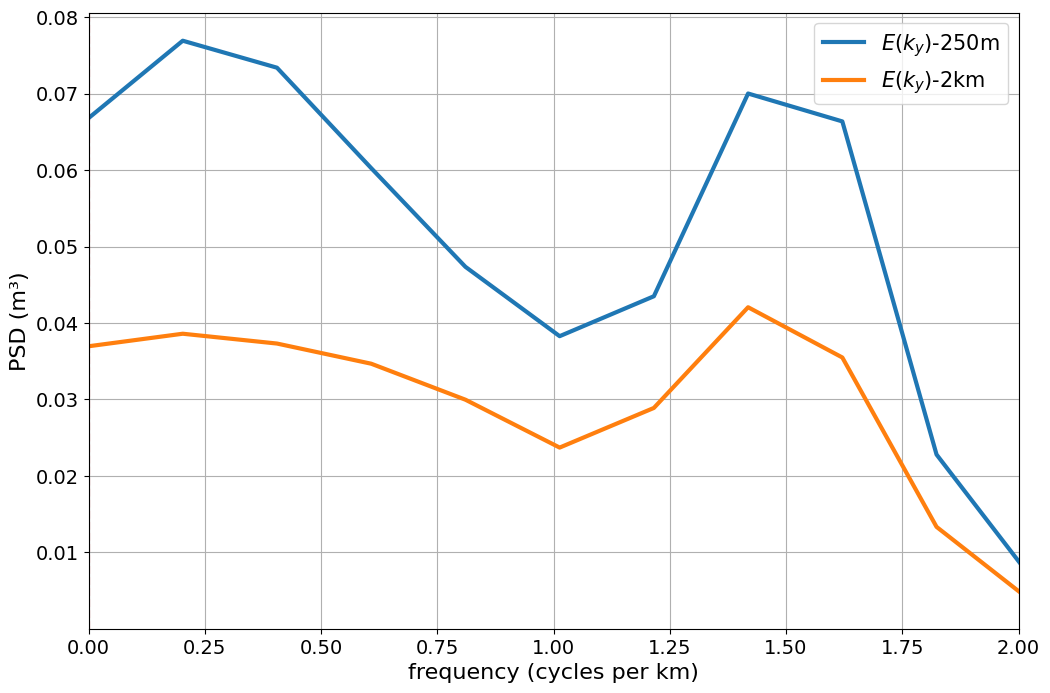

In [6]:

fig,ax=plt.subplots(figsize=(12,8))
inds=np.where(abs(kx2[0,:]) > 0.0005)[0]
Ey=np.sum(Eta,axis=1)*dkx
Ey2=np.sum(Eta[:,inds],axis=1)*dkx
                              
plt.plot(ky2[:,0]*1000, Ey, lw=3, label=r'$E(k_y)$-250m')
plt.plot(ky2[:,0]*1000, Ey2, lw=3, label=r'$E(k_y)$-2km ')

plt.xlim([0., 2])
plt.grid()
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('frequency (cycles per km)', fontsize=16)
plt.ylabel('PSD (m³)', fontsize=16)
plt.axvline(1/500., c='r', ls='--')
ax.grid(True)
#ax.set_ylim([-25 ,2]);
fig.savefig(pth_results+'SSH_along_track_spectra_'+cycle+'_'+tracks+'_'+side+'_'+lonlat+'.pdf')
 
